In [1]:
from matplotlib import pylab as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import IntegerType, StringType, StructField, StructType

# Spark Initialization

In [2]:
spark = (
    SparkSession.builder.master("local[*]")
    .appName("Sales")
    .config("spark.ui.port", "4050")
    .getOrCreate()
)
spark

22/11/21 23:28:54 WARN Utils: Your hostname, anderson-mini-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.0.10 instead (on interface enp3s0)
22/11/21 23:28:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/21 23:28:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data

## Read CSV

In [3]:
data = (
    spark.read.option("inferSchema", True)
    .option("delimiter", ",")
    .option("header", True)
    .csv("vgsales.csv")
)

# type casting
data = data.withColumn("Year", data.Year.cast(t.IntegerType()))

# Set Temporary Table
data.createOrReplaceTempView("sales")

print("n rows:", data.count())
data.show(3)
data.limit(3).toPandas()

n rows: 16598
+----+-----------------+--------+----+--------+---------+--------+--------+--------+-----------+------------+
|Rank|             Name|Platform|Year|   Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+-----------------+--------+----+--------+---------+--------+--------+--------+-----------+------------+
|   1|       Wii Sports|     Wii|2006|  Sports| Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|Super Mario Bros.|     NES|1985|Platform| Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|   Mario Kart Wii|     Wii|2008|  Racing| Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
+----+-----------------+--------+----+--------+---------+--------+--------+--------+-----------+------------+
only showing top 3 rows



,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82


In [4]:
data.dtypes

[('Rank', 'int'),
 ('Name', 'string'),
 ('Platform', 'string'),
 ('Year', 'int'),
 ('Genre', 'string'),
 ('Publisher', 'string'),
 ('NA_Sales', 'double'),
 ('EU_Sales', 'double'),
 ('JP_Sales', 'double'),
 ('Other_Sales', 'double'),
 ('Global_Sales', 'double')]

# EDA
## Handling Missing Values

In [5]:
def display_missing_count(df):
    missing_df = df.select(
        [
            F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c)
            for c in df.columns
        ]
    ).toPandas()
    display(missing_df)


display_missing_count(data)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,0,0,0,271,0,0,0,0,0,0,0


In [6]:
from functools import reduce


def filter_missing_values(df):
    return df.where(
        reduce(
            lambda a, b: a & b,
            [~F.isnan(col) & F.col(col).isNotNull() for col in df.columns],
        )
    )


data = filter_missing_values(data)
display_missing_count(data)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,0,0,0,0,0,0,0,0,0,0,0


## What genre games have been made the most?

<AxesSubplot:xlabel='Genre'>

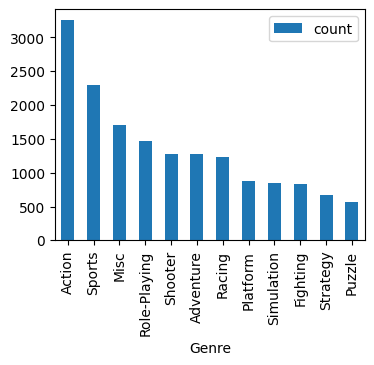

In [7]:
fig, ax = plt.subplots(1, figsize=(4, 3))
(
    data.groupBy("Genre")
    .count()
    .orderBy(F.col("count").desc())
    .toPandas()
    .plot(x="Genre", y="count", kind="bar", ax=ax)
)

In [8]:
data.toPandas()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16322,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16323,16597,Men in Black II: Alien Escape,GC,2003,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16324,16598,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16325,16599,Know How 2,DS,2010,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


In [9]:
query = """
SELECT *
FROM (SELECT *,
             RANK(Global_Sales) OVER (PARTITION BY Year ORDER BY Global_Sales) as rank_sales
      FROM sales) t
WHERE t.rank_sales = 1
ORDER BY Year
"""
df = spark.sql(query).toPandas()
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,rank_sales
0,16060,PDC World Championship Darts 2008,PSP,NaN,Sports,Oxygen Interactive,0.01,0.00,0.0,0.0,0.01,1
1,16061,WRC: FIA World Rally Championship,PC,NaN,Racing,Black Bean Games,0.00,0.01,0.0,0.0,0.01,1
2,16068,Aquaman: Battle for Atlantis,XB,NaN,Action,Unknown,0.01,0.00,0.0,0.0,0.01,1
3,16194,Homeworld Remastered Collection,PC,NaN,Strategy,N/A,0.00,0.01,0.0,0.0,0.01,1
4,16197,Shorts,DS,NaN,Platform,Unknown,0.01,0.00,0.0,0.0,0.01,1


# to Parquet

In [24]:
# mode: overwrite, append (새로운 파일이 만들어짐)
data.write.mode("overwrite").parquet("sales.parquet")

In [26]:
!ls -lsa sales.parquet 

total 452
  4 drwxr-xr-x 3 anderson anderson   4096 11월 21 23:52 .
  4 drwxrwxr-x 4 anderson anderson   4096 11월 21 23:54 ..
  4 drwxrwxr-x 2 anderson anderson   4096 11월 21 23:52 .ipynb_checkpoints
432 -rw-r--r-- 1 anderson anderson 438869 11월 21 23:52 part-00000-d72244c7-32fb-4ca5-97de-b26d15b692d2-c000.snappy.parquet
  4 -rw-r--r-- 1 anderson anderson   3440 11월 21 23:52 .part-00000-d72244c7-32fb-4ca5-97de-b26d15b692d2-c000.snappy.parquet.crc
  0 -rw-r--r-- 1 anderson anderson      0 11월 21 23:52 _SUCCESS
  4 -rw-r--r-- 1 anderson anderson      8 11월 21 23:52 ._SUCCESS.crc


In [ ]:
!rm sales.parquet/.